# PART 4: Dynamic Hedging

> Import packages

In [19]:
from scipy.stats import norm
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import least_squares
from scipy.optimize import brentq
import matplotlib.pylab as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")

In [3]:
np.set_printoptions(precision = 3)

plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 10

 # <a id = "top">Contents</a>

# [1. Function Defination](#p1)
# [2. Calculate Hedging Error](#p2)
# [3. Plot and Discription Statistics](#p3)

#  <a id = "p1"> 1.<font color = "green">Function Defination [(back to contents)](#top)

Black-Scholes introduced the notion of dynamic delta hedging - by executing delta hedges instantaneously, we ensure that our portfolio is delta neutral, and consequently hedged the exposure of our call position using the underlying stock and the risk-free bond. 

The hedged portfolio is $V_t=\phi_tS_t+\psi_tB_t$, where 
\begin{equation*}
\phi_t=\Delta_t=\frac{\partial C}{\partial S}=\Phi\left(\frac{\log\frac{S}{K}+\left(r+\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}\right)
\end{equation*}

and

\begin{equation*}
\psi_tB_t=-Ke^{-rT}\Phi\left(\frac{\log\frac{S}{K}+\left(r-\frac{\sigma^2}{2}\right)T}{\sigma\sqrt{T}}\right)
\end{equation*}


In [4]:
def phi(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    return norm.cdf(d1)


def psi_Bt(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return -K*np.exp(-r*T)*norm.cdf(d2)


def simulate_Brownian_Motion(paths, steps, T):
    deltaT = T/steps
    t = np.linspace(0, T, steps+1)
    X = np.c_[np.zeros((paths, 1)),
              np.random.randn(paths, steps)]
    return t, np.cumsum(np.sqrt(deltaT) * X, axis=1)


In [5]:
def calc_error(blackscholespath, T, maturity, S0, K, r, sigma, dt):
    
    stockhedge_errors = []
    bondhedge_errors = []
    
    for t, S_t in zip(T, blackscholespath):
        stock_pos = phi(S_t, K, r, sigma, maturity-t)*S_t
        bond_pos = psi_Bt(S_t, K, r, sigma, maturity-t)
        V_t = stock_pos + bond_pos
        if t == 0.0:
            stockhedge_errors.append(0)
            bondhedge_errors.append(0)
        else:
            stockhedge_errors.append(prev_phi*S_t - stock_pos)
            bondhedge_errors.append(prev_bond_pos*np.exp(r*dt) - bond_pos)
        prev_phi = phi(S_t, K, r, sigma, maturity-t)
        prev_bond_pos = bond_pos

    return sum(stockhedge_errors)+sum(bondhedge_errors)

#  <a id = "p2"> 2.<font color = "green">Calculate Hedging Error [(back to contents)](#top)

In [6]:
maturity = 1/12
r = 0.05
S0 = 100.0
K = 100.0
sigma = 0.2

In [7]:
total_error_21 = []
steps = 21
dt = maturity / steps
for paths in range(50000):
    T, W_T = simulate_Brownian_Motion(1, steps, maturity)
    blackscholespath = S0*np.exp((r-sigma**2/2)*T + sigma*W_T[0])
    calc_error_21 = calc_error(blackscholespath, T, maturity, S0, K, r, sigma, dt)
    total_error_21.append(calc_error_21)

In [8]:
total_error_84 = []
steps = 84
dt = maturity / steps
for paths in range(50000):
    T, W_T = simulate_Brownian_Motion(1, steps, maturity)
    blackscholespath = S0*np.exp((r-sigma**2/2)*T + sigma*W_T[0])
    calc_error_84 = calc_error(blackscholespath, T, maturity, S0, K, r, sigma, dt)
    total_error_84.append(calc_error_84)

#  <a id = "p3"> 3.<font color = "green"> Plot and Discription Statistics [(back to contents)](#top)

In [9]:
def err_histogram(err_results, N):
    plt.hist(err_results,weights = np.ones(len(err_results))/len(err_results),
             bins = np.linspace(-2,2,40), color = "#68AC57")
    plt. gca(). yaxis. set_major_formatter(PercentFormatter(1)) 
    plt.title(f'Histogram of Hedging Error\n(Maturity = {N} days)') 
    plt.xlabel('Hedging Error')
    plt. ylabel('Frequency')
    plt. yticks(np. arange(0,0.3,0.05))
    return

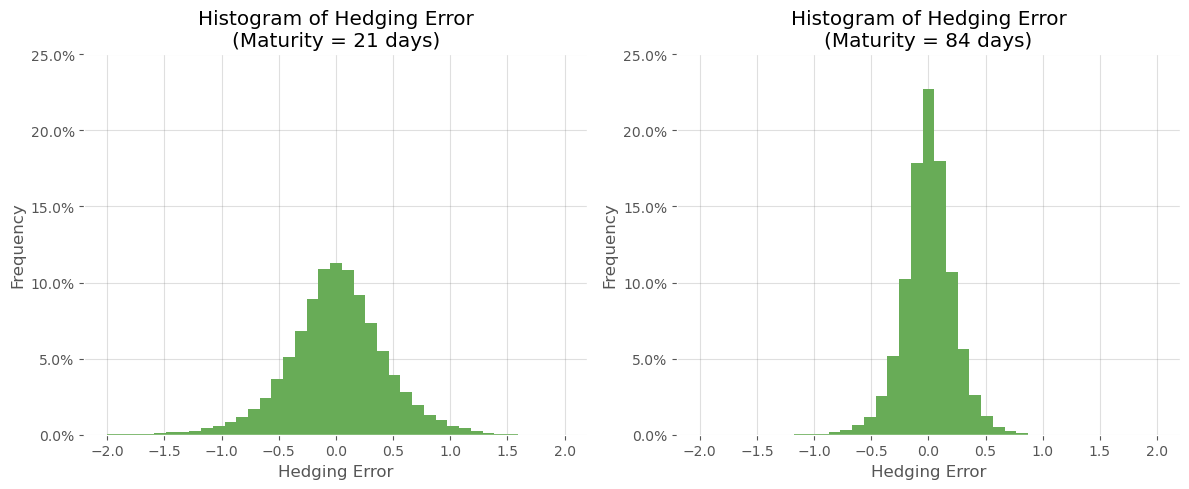

In [10]:
from matplotlib.ticker import PercentFormatter

plt.figure(figsize=(12, 5))
plt.subplot(121)
err_histogram(total_error_21, 21)


plt.subplot(122)
err_histogram(total_error_84, 84)


plt.tight_layout()
#plt.savefig('/Users/xiangsihan/Desktop/figure5.pdf', format='pdf')


In [13]:
mean_21 = np.mean(total_error_21)
mean_84 = np.mean(total_error_84)
std_21 = np.std(total_error_21)
std_84 = np.std(total_error_84)

In [15]:
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T)) 
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

In [16]:
option_premium = BlackScholesCall(S0, K, r, sigma, maturity)

In [17]:
std_premium_21 = std_21/option_premium*100
std_premium_84 = std_84/option_premium*100

In [22]:
result = pd.DataFrame({"Number of Trades": [21,84],
                      "Mean": [mean_21,mean_84],
                      "Standard Deviation": [std_21, std_84],
                      "Std of Option Premium (%)": [std_premium_21, std_premium_84]})

In [23]:
result

,Number of Trades,Mean,Standard Deviation,Std of Option Premium (%)
0,21,0.002971,0.426356,16.972323
1,84,0.000106,0.218400,8.694053
